Make a plot to see the correlation of tanimoto similarity and r2 fingerprint cosine similarity

Have to first convert smiles string to inchi key, then convert to pubmed compound ID, and compute their similarity using pubmed's subgraph fingerprint (881 bit long binary vector ) 

In [2]:
from rdkit import Chem
import pickle, pubchempy as pcp
import requests
import torch 


In [3]:
#  helper functions 
def smiles_to_inchi_key(smile):
    molecule = Chem.MolFromSmiles(smile)

    # Convert the RDKit molecule to an InChI key
    inchi_key = Chem.inchi.MolToInchiKey(molecule)
    return inchi_key



In [4]:
# def get_pubchem_cids(inchi_keys):
#     url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/cids/JSON"
#     data = {'inchikeys': ','.join(inchi_keys)}
#     response = requests.post(url, data=data)

#     if response.status_code == 200:
#         cids = response.json().get('IdentifierList', {}).get('CID', [])
#         return cids
#     else:
#         raise Exception("Error retrieving data from PubChem")

def lookup_pubchem_cid(inchi_key):
    base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
    compound_format = "inchikey"
    output = "JSON"
    request_url = f"{base_url}/compound/{compound_format}/{inchi_key}/cids/{output}"

    response = requests.get(request_url)
    if response.status_code == 200:
        data = response.json()
        return data.get("IdentifierList", {}).get("CID", [])[0]
    else:
        return "Error: Unable to retrieve data"
    
# def get_pubmed_ids_from_inchi(inchi_keys):
#     pubmed_ids = []
#     for inchi_key in inchi_keys:
#         try:
#             compound = pcp.get_compounds(inchi_key, 'inchikey')[0]
#             pubmed_ids.append(compound.cid)
#         except Exception as e:
#             print(f"Error retrieving data for InChI key {inchi_key}: {e}")
#             pubmed_ids.append(None)
#     return pubmed_ids


In [5]:
# processing smiles dataset 
with open('/root/gurusmart/MorganFP_prediction/James_dataset_zips/SMILES_dataset/test/SMILES/index.pkl', 'rb') as file:
    smart_test_data_index = pickle.load(file)
len(smart_test_data_index), smart_test_data_index[0]
smart_test_data_index = list(smart_test_data_index.items())
smart_test_data_index.sort()

In [6]:
smart_test_data_index[0:3]

[(0, 'Br.CCCN(CCC)C1CCc2cccc(O)c2C1'),
 (1, 'Br.COC1CC=C2CCN3CCC4=C(CC(=O)OC4)C23C1'),
 (2, 'Br.Oc1cc2c(c(Cl)c1O)CCNCC2c1ccccc1')]

In [7]:
import tqdm
all_test_set_inchi_keys = [ smiles_to_inchi_key(s) for _, s in tqdm.tqdm(smart_test_data_index)]

100%|██████████| 13718/13718 [00:06<00:00, 1966.89it/s]


In [8]:
test_cids = [pcp.get_compounds(inchi_key, 'inchikey') for inchi_key in tqdm.tqdm(all_test_set_inchi_keys[:500])]


100%|██████████| 500/500 [05:06<00:00,  1.63it/s]


In [9]:
# index_cid_pairs = [] 
index_cid_pairs = [[it, compounds[0].cid ] for it, compounds in enumerate(test_cids) if len(compounds)>0]
    

In [10]:
[id for _ , id in index_cid_pairs ]

[6917794,
 23446092,
 11957706,
 3024,
 7839,
 14503990,
 50899958,
 50899958,
 456387,
 21774505,
 495221,
 137843,
 74051368,
 71442208,
 562564,
 562564,
 163137014,
 12574163,
 78167205,
 5245928,
 76445682,
 73836307,
 73836011,
 54004088,
 54004088,
 163111517,
 1658,
 76032547,
 139291438,
 74051758,
 1665,
 1665,
 7746,
 73837799,
 73836985,
 78063566,
 2999,
 2999,
 4542,
 4542,
 4542,
 74052102,
 85160675,
 85160675,
 85160675,
 73836744,
 73818194,
 73818194,
 73818194,
 73818194,
 163113314,
 74408267,
 74408267,
 74408267,
 73880872,
 72738632,
 163086579,
 72835532,
 72835532,
 163112700,
 85111538,
 75059738,
 163111962,
 163143450,
 85246748,
 85246705,
 85246705,
 85246705,
 72756313,
 70696939,
 13658161,
 14487435,
 162992515,
 85117302,
 73193672,
 78440690,
 582240,
 13994061,
 102341997,
 372629,
 620391,
 73719330,
 5491947,
 5491947,
 75049040,
 76152724,
 76152724,
 163192253,
 85069478,
 71717803,
 73837908,
 558826,
 81184,
 81184,
 4486397,
 23072575,
 67521

In [11]:
dataset_path = "/root/gurusmart/MorganFP_prediction/James_dataset_zips/SMILES_dataset/test"
all_r2_fp = dict([[index, torch.load(f"{dataset_path}/R2-6144FP/{index}.pt")] for index , _ in index_cid_pairs])
all_hyun_fp = dict([[index,torch.load(f"{dataset_path}/HYUN_FP/{index}.pt")] for index , _ in index_cid_pairs])

In [12]:
# inchi key -> index in local system
inchi_key_to_index = dict([[a,b] for b,a in index_cid_pairs])


In [13]:
def tanimoto_sim(f1,f2):
    intersection = torch.sum(f1*f2)
    union = torch.sum(f1+f2)-intersection
    return intersection/union

cos_sim=torch.nn.CosineSimilarity(dim=0)


In [14]:
dataset_path = "/root/gurusmart/MorganFP_prediction/James_dataset_zips/SMILES_dataset/test"
def get_all_similarities(inchi_key1, inchi_key2):
    # return cosine of r2, cosine of hyun, tanimoto of r2, tanimoto of hyun 
    hyun_fp1, hyun_fp2 = all_hyun_fp[inchi_key_to_index[inchi_key1]].float(), all_hyun_fp[inchi_key_to_index[inchi_key2]].float()
    r2_fp1, r2_fp2 = all_r2_fp[inchi_key_to_index[inchi_key1]].float(), all_r2_fp[inchi_key_to_index[inchi_key2]].float()
    return [cos_sim(r2_fp1, r2_fp2), cos_sim(hyun_fp1, hyun_fp2), tanimoto_sim(r2_fp1, r2_fp2), tanimoto_sim(hyun_fp1, hyun_fp2), ]

In [15]:
# construct of list, each item is [ichi_key 1, ichi_key 2, tanimoto from pubmed, cosine of r2, cosine of hyun, tanimoto of r2, tanimoto of hyun  ]
similarities = []

# Open the file and read each line
with open('/root/gurusmart/MorganFP_prediction/task_scripts/similarities_from_NIH_server_500.txt', 'r') as file:
    for line in (file):
        # Strip newline characters and add to the list
        ichi_key_1, ichi_key_2, pubmed_tanimoto = line.split()
        ichi_key_1, ichi_key_2 = int(ichi_key_1), int(ichi_key_2)
        similarities.append([ichi_key_1, ichi_key_2, pubmed_tanimoto])

In [16]:
for it, (ichi_key_1, ichi_key_2, pubmed_tanimoto )in tqdm.tqdm(enumerate(similarities)):
    similarities[it]+=get_all_similarities(ichi_key_1, ichi_key_2)

98818it [00:14, 6840.02it/s]


In [17]:
ichi_key_1, ichi_key_2, pubmed_tanimoto, cosine_r2, cosine_hyun, tanimoto_r2, tanimoto_hyun  = zip(*similarities)

In [23]:
pubmed_tanimoto = [int(n) for n in pubmed_tanimoto]

Text(0, 0.5, 'cosine_r2')

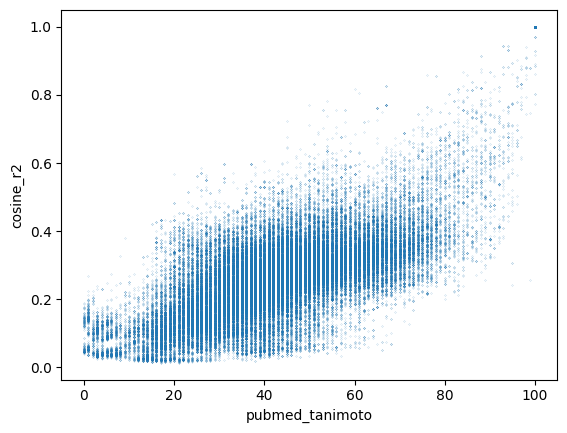

In [30]:
from matplotlib import pyplot as plt
plt.scatter(pubmed_tanimoto, cosine_r2,s=0.01)
plt.xlabel("pubmed_tanimoto")
plt.ylabel("cosine_r2")

Text(0, 0.5, 'tanimoto_r2')

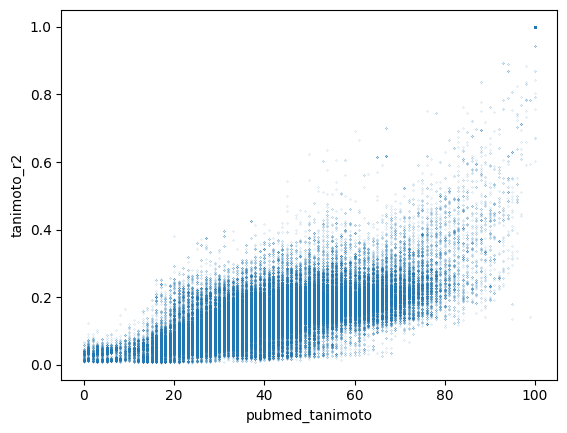

In [31]:
plt.scatter(pubmed_tanimoto, tanimoto_r2, s=0.01)
plt.xlabel("pubmed_tanimoto")
plt.ylabel("tanimoto_r2")

Text(0, 0.5, 'cosine_hyun')

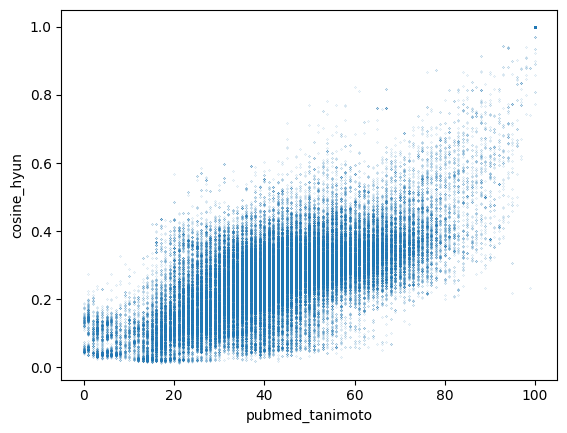

In [33]:
plt.scatter(pubmed_tanimoto, cosine_hyun, s=0.01)
plt.xlabel("pubmed_tanimoto")
plt.ylabel("cosine_hyun")

Text(0, 0.5, 'tanimoto_r2')

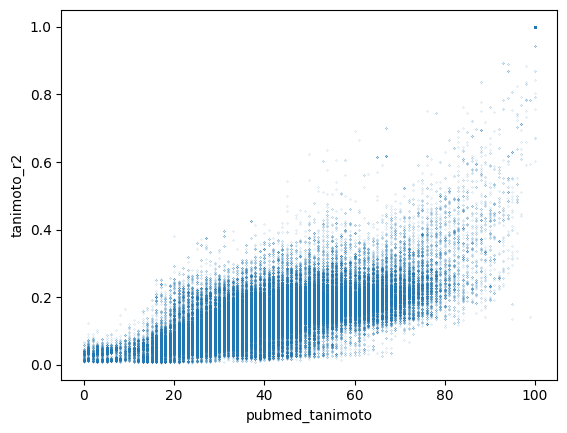

: 

In [34]:
plt.scatter(pubmed_tanimoto, tanimoto_r2,s=0.01)
plt.xlabel("pubmed_tanimoto")
plt.ylabel("tanimoto_r2")